In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

## 1. Data Collection

In [89]:
now = datetime.now()
ticker = "^NSEI"
start = datetime(now.year - 10, now.month, now.day)
end = now
price_df = yf.download(ticker, start, end)

# Calculate RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    diff = data.diff(1).dropna()
    gain = diff.mask(diff < 0, 0)
    loss = diff.mask(diff > 0, 0).abs()
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

price_df['RSI'] = calculate_rsi(price_df['Close'])

# Calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

macd, signal_line = calculate_macd(price_df['Close'])
price_df['MACD'] = macd
price_df['MACD_Signal'] = signal_line

# Calculate EMA 50
price_df['EMA_50'] = price_df['Close'].ewm(span=50, adjust=False).mean()

# Calculate SMA 20
price_df['SMA_20'] = price_df['Close'].rolling(window=20).mean()

# Calculate Stochastic RSI
def calculate_stoch_rsi(data, window=14, k_window=3, d_window=3):
    rsi = calculate_rsi(data, window)
    min_rsi = rsi.rolling(window=window).min()
    max_rsi = rsi.rolling(window=window).max()
    stoch_rsi = (rsi - min_rsi) / (max_rsi - min_rsi)
    k_line = stoch_rsi.rolling(window=k_window).mean()
    d_line = k_line.rolling(window=d_window).mean()
    return k_line, d_line

price_df['StochRSI_K'], price_df['StochRSI_D'] = calculate_stoch_rsi(price_df['Close'])

print(price_df.columns.tolist())

C:\Users\Krish Patel\AppData\Local\Temp\ipykernel_20764\204276141.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_df = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed

[('Close', '^NSEI'), ('High', '^NSEI'), ('Low', '^NSEI'), ('Open', '^NSEI'), ('Volume', '^NSEI'), ('RSI', ''), ('MACD', ''), ('MACD_Signal', ''), ('EMA_50', ''), ('SMA_20', ''), ('StochRSI_K', ''), ('StochRSI_D', '')]


In [ ]:
from features.macro_features import get_macro_features

macro_df = get_macro_features(
    start=price_df.index.min(),
    end=price_df.index.max()
)

df = price_df.merge(
    macro_df,
    left_index=True,
    right_index=True,
    how="inner"
)
df.dropna(inplace=True)
df = df.reset_index(drop=True)

c:\Users\Krish Patel\Workspace\Projects\stock_prediction\experiment\macro_features.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
c:\Users\Krish Patel\Workspace\Projects\stock_prediction\experiment\macro_features.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
c:\Users\Krish Patel\Workspace\Projects\stock_prediction\experiment\macro_features.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
c:\Users\Krish Patel\Workspace\Projects\stock_prediction\experiment\macro_features.py:16: FutureWarning: YF.download() has changed argument au

In [91]:
df.head()

Price,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,EMA_50,SMA_20,StochRSI_K,StochRSI_D,sp500_ret,nasdaq_ret,vix_ret,crude_ret,usd_inr_ret
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,,,,,,,^GSPC,^IXIC,^INDIAVIX,CL=F,USDINR=X
0,7368.850098,7380.350098,7308.149902,7321.700195,338500,65.888113,-47.033910,-66.948932,7257.228239,7170.752539,0.835695,0.602622,0.023869,0.028884,-0.073909,0.019259,-0.007449
1,7475.600098,7483.950195,7406.049805,7429.549805,278600,68.493658,-18.072276,-57.173601,7265.791841,7174.332544,1.000000,0.826492,0.004094,0.002947,0.017140,0.007558,-0.006919
2,7485.350098,7505.899902,7444.100098,7505.399902,281700,63.835717,5.602193,-44.618442,7274.401969,7174.145044,0.960188,0.931961,0.003499,0.000850,-0.050026,-0.002597,-0.005284
3,7531.799805,7539.000000,7424.299805,7436.100098,245100,70.417150,41.996704,-16.303228,7292.442172,7190.727515,0.957074,0.959150,-0.011240,-0.012623,0.032998,-0.036939,0.001733
4,7486.149902,7547.100098,7447.399902,7545.350098,224700,64.733254,51.911702,-2.660242,7300.038553,7204.250000,0.947908,0.955057,0.005052,0.005498,-0.051976,0.049041,0.004639


In [92]:
df.tail()

Price,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,EMA_50,SMA_20,StochRSI_K,StochRSI_D,sp500_ret,nasdaq_ret,vix_ret,crude_ret,usd_inr_ret
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,,,,,,,^GSPC,^IXIC,^INDIAVIX,CL=F,USDINR=X
2211,25876.849609,26133.199219,25858.449219,26106.500000,328500,52.126508,46.380703,57.878144,25911.616027,26044.980176,0.796048,0.871708,-0.003440,0.001576,-0.006986,-0.019954,-0.000741
2212,25683.300781,25940.599609,25623.000000,25840.400391,348800,40.461616,10.851184,48.472752,25902.662488,26034.217676,0.471083,0.729658,0.000077,-0.004421,0.065327,0.031613,-0.003346
2213,25790.250000,25813.150391,25473.400391,25669.050781,275800,36.203471,-8.577432,37.062715,25898.254155,26021.382715,0.143917,0.470349,0.006475,0.008149,0.031132,0.023546,0.000456
2214,25732.300781,25899.800781,25603.300781,25897.349609,339500,34.533968,-28.324264,23.985319,25891.746179,26006.632715,0.000000,0.205000,0.001578,0.002642,0.040256,0.006428,0.003677
2215,25665.599609,25791.750000,25603.949219,25648.550781,393100,33.790320,-48.793536,9.429548,25882.877686,25996.907715,0.000000,0.047972,-0.001939,-0.001013,-0.014952,0.027731,-0.001145


## 2. Data Exploraion & Visualization

In [93]:
df.shape

(2216, 17)

In [94]:
df.isna().sum()

Price        Ticker   
Close        ^NSEI        0
High         ^NSEI        0
Low          ^NSEI        0
Open         ^NSEI        0
Volume       ^NSEI        0
RSI                       0
MACD                      0
MACD_Signal               0
EMA_50                    0
SMA_20                    0
StochRSI_K                0
StochRSI_D                0
sp500_ret    ^GSPC        0
nasdaq_ret   ^IXIC        0
vix_ret      ^INDIAVIX    0
crude_ret    CL=F         0
usd_inr_ret  USDINR=X     0
dtype: int64

In [95]:
df.describe()

Price,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,EMA_50,SMA_20,StochRSI_K,StochRSI_D,sp500_ret,nasdaq_ret,vix_ret,crude_ret,usd_inr_ret
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,,,,,,,^GSPC,^IXIC,^INDIAVIX,CL=F,USDINR=X
count,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,15311.625100,15387.792371,15229.802696,15318.524777,3.368058e+05,56.119318,54.681364,54.979220,15122.167430,15238.677040,0.499088,0.499720,0.000519,0.000681,0.001515,-0.001049,0.000143
std,5634.506881,5654.660062,5613.182189,5634.462847,1.891153e+05,17.197535,161.071503,150.625148,5563.936983,5611.961911,0.341846,0.327894,0.011134,0.013606,0.052643,0.075305,0.003556
min,7368.850098,7380.350098,7308.149902,7321.700195,0.000000e+00,2.022397,-1005.837460,-848.332753,7257.228239,7170.752539,0.000000,0.000000,-0.119841,-0.123213,-0.297503,-3.059661,-0.022850
25%,10551.062744,10611.187256,10503.262451,10559.949707,2.174000e+05,43.404807,-25.497905,-21.662897,10544.145676,10541.073181,0.171287,0.187133,-0.003532,-0.005023,-0.025771,-0.011786,-0.001635
50%,14539.275391,14645.200195,14427.074707,14544.174805,2.796500e+05,56.101793,65.944514,65.080753,13954.737740,14483.863745,0.485199,0.487532,0.000804,0.001278,-0.003180,0.002187,0.000022
75%,19358.237793,19434.575195,19297.336914,19377.650391,3.968250e+05,68.498965,147.124246,144.975818,19044.647447,19343.866895,0.837883,0.821677,0.005818,0.007577,0.023027,0.013668,0.001712
max,26328.550781,26373.199219,26210.050781,26333.699219,1.811000e+06,99.582373,451.083428,413.985339,25913.035064,26044.980176,1.000000,1.000000,0.093828,0.093460,0.656250,0.376623,0.026747


In [96]:
df.head()

Price,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,EMA_50,SMA_20,StochRSI_K,StochRSI_D,sp500_ret,nasdaq_ret,vix_ret,crude_ret,usd_inr_ret
Ticker,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,,,,,,,^GSPC,^IXIC,^INDIAVIX,CL=F,USDINR=X
0,7368.850098,7380.350098,7308.149902,7321.700195,338500,65.888113,-47.033910,-66.948932,7257.228239,7170.752539,0.835695,0.602622,0.023869,0.028884,-0.073909,0.019259,-0.007449
1,7475.600098,7483.950195,7406.049805,7429.549805,278600,68.493658,-18.072276,-57.173601,7265.791841,7174.332544,1.000000,0.826492,0.004094,0.002947,0.017140,0.007558,-0.006919
2,7485.350098,7505.899902,7444.100098,7505.399902,281700,63.835717,5.602193,-44.618442,7274.401969,7174.145044,0.960188,0.931961,0.003499,0.000850,-0.050026,-0.002597,-0.005284
3,7531.799805,7539.000000,7424.299805,7436.100098,245100,70.417150,41.996704,-16.303228,7292.442172,7190.727515,0.957074,0.959150,-0.011240,-0.012623,0.032998,-0.036939,0.001733
4,7486.149902,7547.100098,7447.399902,7545.350098,224700,64.733254,51.911702,-2.660242,7300.038553,7204.250000,0.947908,0.955057,0.005052,0.005498,-0.051976,0.049041,0.004639


In [97]:
df = df.reset_index()

In [98]:
df.head()

Price,index,Close,High,Low,Open,Volume,RSI,MACD,MACD_Signal,EMA_50,SMA_20,StochRSI_K,StochRSI_D,sp500_ret,nasdaq_ret,vix_ret,crude_ret,usd_inr_ret
Ticker,,^NSEI,^NSEI,^NSEI,^NSEI,^NSEI,,,,,,,,^GSPC,^IXIC,^INDIAVIX,CL=F,USDINR=X
0,0,7368.850098,7380.350098,7308.149902,7321.700195,338500,65.888113,-47.033910,-66.948932,7257.228239,7170.752539,0.835695,0.602622,0.023869,0.028884,-0.073909,0.019259,-0.007449
1,1,7475.600098,7483.950195,7406.049805,7429.549805,278600,68.493658,-18.072276,-57.173601,7265.791841,7174.332544,1.000000,0.826492,0.004094,0.002947,0.017140,0.007558,-0.006919
2,2,7485.350098,7505.899902,7444.100098,7505.399902,281700,63.835717,5.602193,-44.618442,7274.401969,7174.145044,0.960188,0.931961,0.003499,0.000850,-0.050026,-0.002597,-0.005284
3,3,7531.799805,7539.000000,7424.299805,7436.100098,245100,70.417150,41.996704,-16.303228,7292.442172,7190.727515,0.957074,0.959150,-0.011240,-0.012623,0.032998,-0.036939,0.001733
4,4,7486.149902,7547.100098,7447.399902,7545.350098,224700,64.733254,51.911702,-2.660242,7300.038553,7204.250000,0.947908,0.955057,0.005052,0.005498,-0.051976,0.049041,0.004639


Text(0, 0.5, 'Close price')

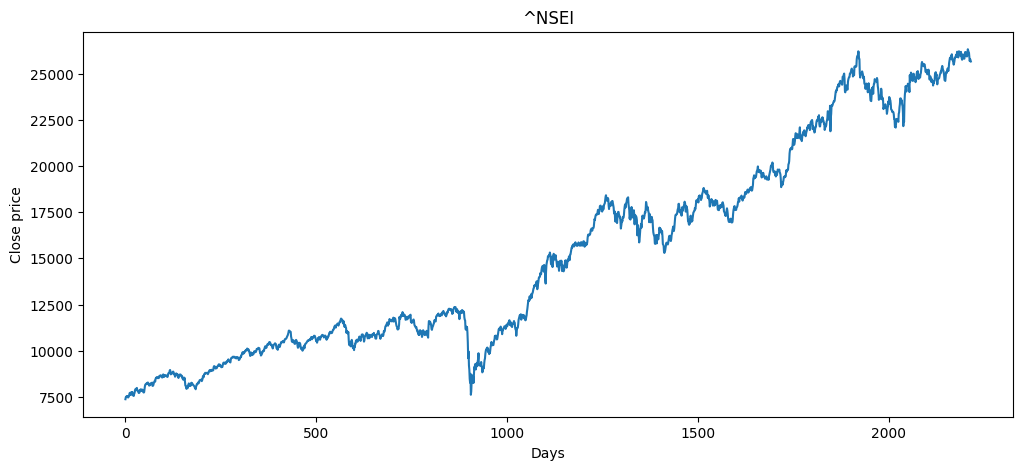

In [99]:
plt.figure(figsize=(12,5))
plt.plot(df.Close)
plt.title(ticker)
plt.xlabel('Days')
plt.ylabel('Close price')

## 3. Feature Engineering

In [100]:
features = ['Open','Close', 'RSI', 'MACD', 'MACD_Signal', 'EMA_50', 'SMA_20', 'StochRSI_K', 'StochRSI_D', 'sp500_ret', 'nasdaq_ret', 'vix_ret', 'crude_ret', 'usd_inr_ret']

time_step = 100
target_cols = ['Close', 'Open']
input_cols = features

data_to_process = df[features]

In [101]:
train_size = int(len(data_to_process) * 0.7)
data_training = data_to_process.iloc[:train_size]
data_testing = data_to_process.iloc[train_size:]

In [102]:
data_training.head()

Price,Open,Close,RSI,MACD,MACD_Signal,EMA_50,SMA_20,StochRSI_K,StochRSI_D,sp500_ret,nasdaq_ret,vix_ret,crude_ret,usd_inr_ret
Ticker,^NSEI,^NSEI,,,,,,,,^GSPC,^IXIC,^INDIAVIX,CL=F,USDINR=X
0,7321.700195,7368.850098,65.888113,-47.033910,-66.948932,7257.228239,7170.752539,0.835695,0.602622,0.023869,0.028884,-0.073909,0.019259,-0.007449
1,7429.549805,7475.600098,68.493658,-18.072276,-57.173601,7265.791841,7174.332544,1.000000,0.826492,0.004094,0.002947,0.017140,0.007558,-0.006919
2,7505.399902,7485.350098,63.835717,5.602193,-44.618442,7274.401969,7174.145044,0.960188,0.931961,0.003499,0.000850,-0.050026,-0.002597,-0.005284
3,7436.100098,7531.799805,70.417150,41.996704,-16.303228,7292.442172,7190.727515,0.957074,0.959150,-0.011240,-0.012623,0.032998,-0.036939,0.001733
4,7545.350098,7486.149902,64.733254,51.911702,-2.660242,7300.038553,7204.250000,0.947908,0.955057,0.005052,0.005498,-0.051976,0.049041,0.004639


In [103]:
data_testing.head()

Price,Open,Close,RSI,MACD,MACD_Signal,EMA_50,SMA_20,StochRSI_K,StochRSI_D,sp500_ret,nasdaq_ret,vix_ret,crude_ret,usd_inr_ret
Ticker,^NSEI,^NSEI,,,,,,,,^GSPC,^IXIC,^INDIAVIX,CL=F,USDINR=X
1551,18093.349609,17891.949219,46.667299,-49.158263,-62.047537,18090.946342,18036.224902,0.803526,0.774151,-0.000712,-0.002652,0.002937,-0.018255,0.006323
1552,17541.949219,17648.949219,34.523125,-99.361524,-72.352685,18055.279220,17984.074805,0.270696,0.559417,0.002495,0.009494,0.181446,-0.016418,-0.000707
1553,17731.449219,17662.150391,40.211335,-112.492513,-80.380651,18039.862403,17957.309863,0.142057,0.338928,-0.012969,-0.019610,0.022517,-0.022339,0.000772
1554,17811.599609,17616.300781,39.373265,-125.155878,-89.335696,18023.252143,17926.497363,0.191804,0.201519,0.014642,0.016741,-0.046866,0.012452,0.000882
1555,17517.099609,17610.400391,40.343007,-134.121726,-98.292902,18007.061878,17904.869922,0.297729,0.210530,0.010452,0.020007,-0.005924,-0.031191,0.002311


## 4. Data Preprocessing

In [104]:
# Scaling down data between 0 and 1
from sklearn.preprocessing import MinMaxScaler

In [105]:
train_size = int(len(df) * 0.7)
data_training = df.iloc[:train_size]
data_testing  = df.iloc[train_size:]

# Target Scaler
target_cols = ['Close', 'Open']
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(data_training[target_cols])

# Input Scaler
input_cols = features
input_scaler = MinMaxScaler(feature_range=(0, 1))
input_scaler.fit(data_training[input_cols])

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [106]:
train_x_scaled = input_scaler.transform(data_training[input_cols])
test_x_scaled = input_scaler.transform(data_testing[input_cols])

train_y_scaled = target_scaler.transform(data_training[target_cols])
test_y_scaled = target_scaler.transform(data_testing[target_cols])

In [107]:
train_x_scaled.shape

(1551, 14)

## 5. Sequence Creation

In [108]:
def create_sequences(x, y, time_step):
    xs, ys = [], []
    for i in range(time_step, len(x)):
        xs.append(x[i-time_step:i])
        ys.append(y[i])
    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(train_x_scaled, train_y_scaled, time_step)

## 6. Model Building

In [109]:
import tensorflow as tf
tf.__version__

'2.20.0'

In [110]:
# ML Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input

In [111]:
model = Sequential()

model.add(Input(shape=(100, x_train.shape[2])))
model.add(LSTM(units=128, activation='tanh', return_sequences=True)) # Give Sequence of output
model.add(LSTM(units=64))
model.add(Dense(25))
model.add(Dense(2))

## 7. Model Training

In [112]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0184
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 7.2177e-04
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 6.3686e-04
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 6.7712e-04
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 6.7993e-04
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 5.5354e-04
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 5.1442e-04
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 5.8940e-04
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 4.8818e-04
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4.9577e-04
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4.5594e-04
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 5.0801e-04
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 6.5827e-04
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 4.0199e-04
Epoch

In [113]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 100, 128)       │        73,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372,905 (1.42 MB)

 Trainable params: 124,301 (485.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 248,604 (971.11 KB)

In [114]:
# Save the trained model
model.save('Model_v1.keras')

## 8. Preparing Test Data

In [118]:
test_input_x = np.concatenate(
    (train_x_scaled[-time_step:], test_x_scaled),
    axis=0
)

test_input_y = np.concatenate(
    (train_y_scaled[-time_step:], test_y_scaled),
    axis=0
)

x_test, y_test = create_sequences(test_input_x, test_input_y, time_step)



In [119]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1451, 100, 14) (1451, 2)
(665, 100, 14) (665, 2)


## 9. Making Prediction

In [120]:
y_predicted = model.predict(x_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


In [121]:
y_pred_actual = target_scaler.inverse_transform(y_predicted)
y_test_actual = target_scaler.inverse_transform(y_test)

In [122]:
# Means should be close
print(y_test_actual[:,0].mean(), y_pred_actual[:,0].mean())

22518.67191318139 22176.0


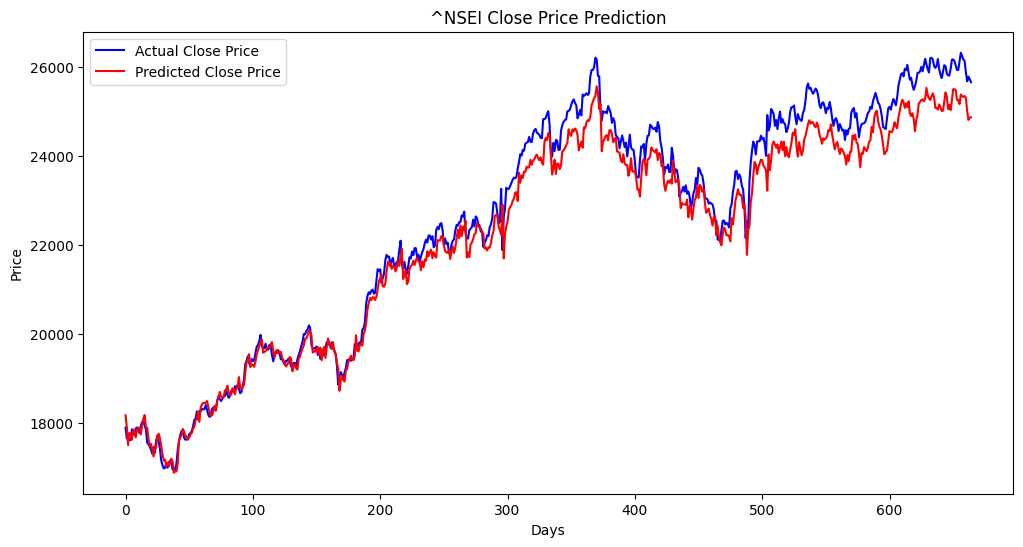

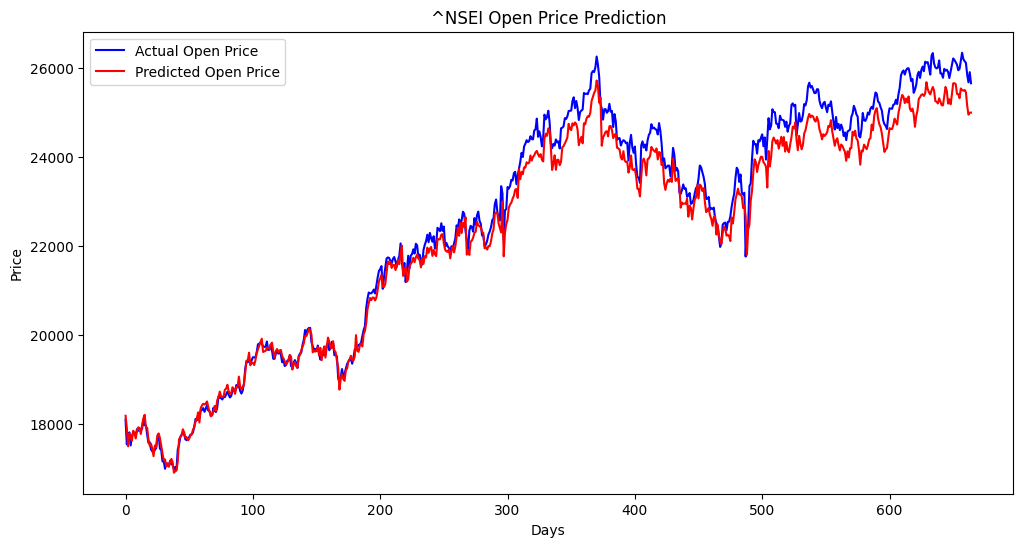

In [123]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual[:, 0], 'b', label='Actual Close Price')
plt.plot(y_pred_actual[:, 0], 'r', label='Predicted Close Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f"{ticker} Close Price Prediction")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_actual[:, 1], 'b', label='Actual Open Price')
plt.plot(y_pred_actual[:, 1], 'r', label='Predicted Open Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f"{ticker} Open Price Prediction")
plt.legend()
plt.show()

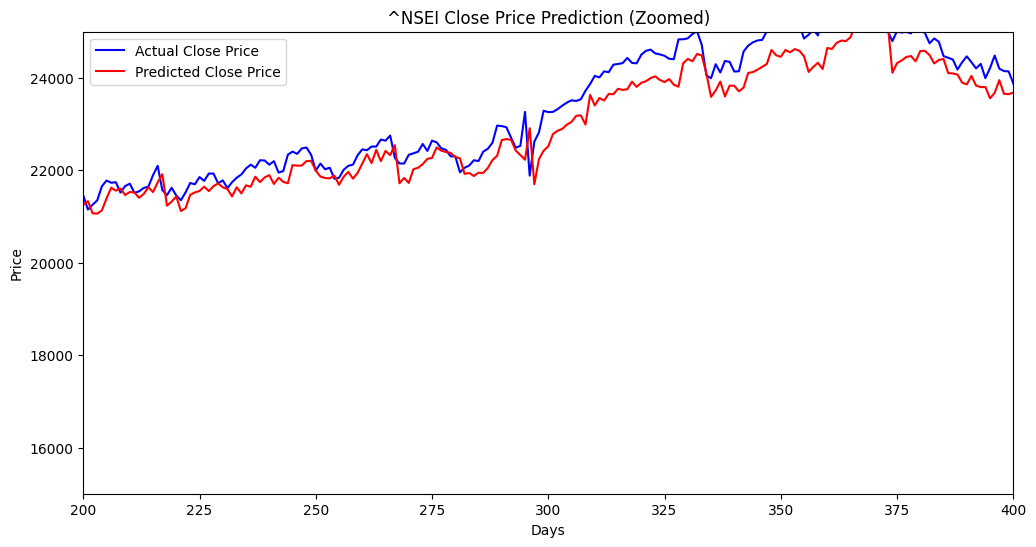

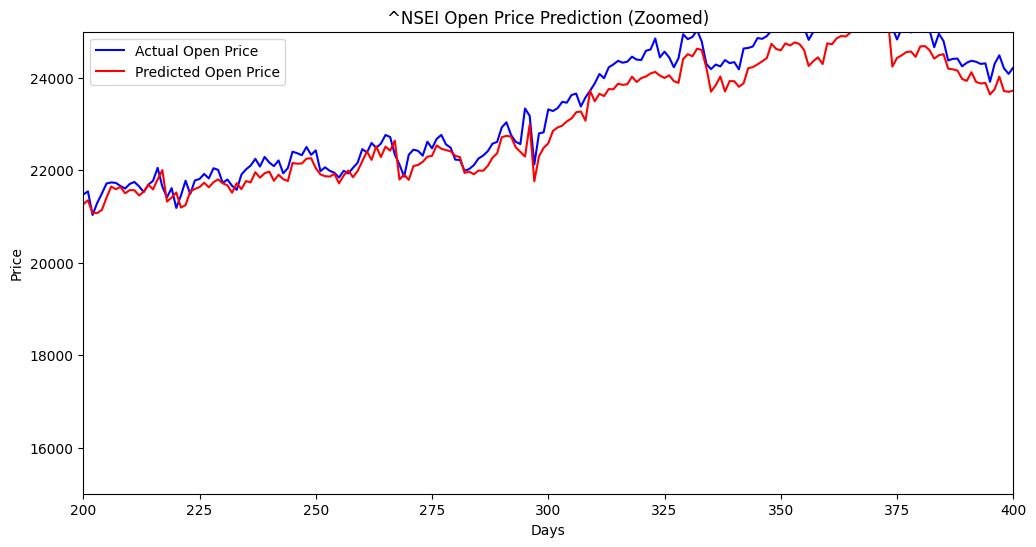

In [124]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual[:, 0], 'b', label = 'Actual Close Price')
plt.plot(y_pred_actual[:, 0], 'r', label = 'Predicted Close Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.xlim(200, 400)
plt.ylim(15000, 25000)
plt.title(f"{ticker} Close Price Prediction (Zoomed)")
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test_actual[:, 1], 'b', label = 'Actual Open Price')
plt.plot(y_pred_actual[:, 1], 'r', label = 'Predicted Open Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.xlim(200, 400)
plt.ylim(15000, 25000)
plt.title(f"{ticker} Open Price Prediction (Zoomed)")
plt.show()

## 10. Model Evaluation

In [125]:
# MSE
from sklearn.metrics import mean_squared_error, r2_score

In [126]:
# Calculate MSE for Close and Open prices separately
mse_close = mean_squared_error(y_test[:, 0], y_predicted[:, 0])
mse_open = mean_squared_error(y_test[:, 1], y_predicted[:, 1])

print(f"Mean Squred Error (MSE) for Close Price: {mse_close}")
print(f"Mean Squred Error (MSE) for Open Price: {mse_open}")

Mean Squred Error (MSE) for Close Price: 0.0017363476083383388
Mean Squred Error (MSE) for Open Price: 0.001172278046019255


In [127]:
# Calculate RMSE for Close and Open prices separately
rmse_close = np.sqrt(mean_squared_error(y_test[:, 0], y_predicted[:, 0]))
rmse_open = np.sqrt(mean_squared_error(y_test[:, 1], y_predicted[:, 1]))

print(f"Root Mean Squred Error (RMSE) for Close Price: {rmse_close}")
print(f"Root Mean Squred Error (RMSE) for Open Price: {rmse_open}")

Root Mean Squred Error (RMSE) for Close Price: 0.04166950453675132
Root Mean Squred Error (RMSE) for Open Price: 0.034238546201894364


In [130]:
np.mean(
    np.sign(y_pred_actual[1:] - y_test_actual[:-1]) ==
    np.sign(y_test_actual[1:] - y_test_actual[:-1])
)


np.float64(0.5128012048192772)

In [128]:
# Calculate R-Squared for Close and Open prices separately
r2_close = r2_score(y_test[:, 0], y_predicted[:, 0])
r2_open = r2_score(y_test[:, 1], y_predicted[:, 1])

print(f"R-Squared for Close Price: {r2_close}")
print(f"R-Squared for Open Price: {r2_open}")

R-Squared for Close Price: 0.9687345851927451
R-Squared for Open Price: 0.978459636118895


In [129]:
# Print model confidence for Close and Open prices separately
r2_close = r2_score(y_test[:, 0], y_predicted[:, 0])
r2_open = r2_score(y_test[:, 1], y_predicted[:, 1])

print(f"Model Confidence (R-squared) for Close Price: {(r2_close * 100):.2f}%")
print(f"Model Confidence (R-squared) for Open Price: {(r2_open * 100):.2f}%")

Model Confidence (R-squared) for Close Price: 96.87%
Model Confidence (R-squared) for Open Price: 97.85%
